# 카메라 스티커 앱 만들기

## 사진 준비하기

* aiffel/camera_sticker/에 images, models폴더 생성 (-p 명령어 이용해서 한번에 생성가능)


In [1]:
#mkdir -p ~/aiffel/camera_sticker/models

* 사용할 이미지들(왕관, 사진) images 폴더에 저장

In [2]:
# 필요 모듈 불러오기
import cv2
import matplotlib.pyplot as plt
import numpy as np
print("🌫🛸")

🌫🛸


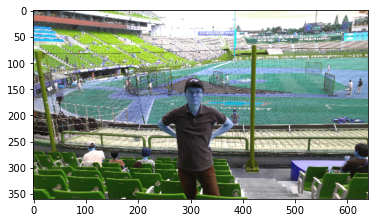

In [3]:
import os
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/image.jpg'
img_bgr = cv2.imread(my_image_path)    #- OpenCV로 이미지를 읽어서
img_bgr = cv2.resize(img_bgr, (640, 360))    # 640x360(16:9)의 크기로 Resize / (4:3)의 경우 640X480
img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관
plt.imshow(img_bgr)
plt.show()

* 다른이미지 라이브러리는 RGB(레드,그린,블루)를 사용하지만, opencv는 BGR을 사용
* matplotlib, dlib사용전에 RGB변환 필요

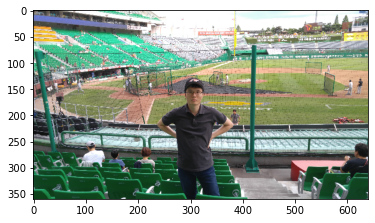

In [4]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

* cv2.IMREAD_COLOR, IMREAD_GRAYSCALE, IMREAD_UNCHANGED
*  = cv2.imread(파일명, flag)  
 1 : 칼라, 0 : 그레이, -1 : 알파채널포함

## 얼굴 검출 (face detection)

* 밝기가 변하는 방향(gradient)을 특징맵으로 사용 - 오브젝트의 특징이 잘 반영됨
* 단일필셀의 gradient 사용시 너무 자세해지므로, 적당한크기(16x16)사용으로 밝기, 어두움의 흐름을 파악

In [5]:
# dlib이용 hog detector 선언
import dlib
detector_hog = dlib.get_frontal_face_detector() #detector선언
print('yeah')

yeah


In [6]:
# img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) # rgb입력 받으므로
dlib_rects = detector_hog(img_rgb, 1) #(image, num of img pyramid)
print('yeah')

yeah


* Image Pyramid - 동일한 이미지의 서로 다른사이즈의 set(가장아래 큰 해상도>>점점줄임)
https://opencv-python.readthedocs.io/en/latest/doc/14.imagePyramid/imagePyramid.html

rectangles[[(289, 146) (325, 182)]]


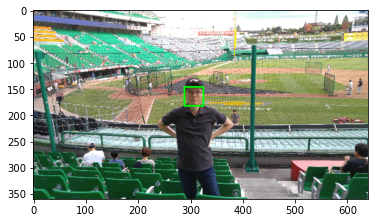

In [7]:
print(dlib_rects)   # 찾은 얼굴영역 좌표(??)

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

## 얼굴 랜드마크

* face land mark loclization - 이목구비 위치 추론  
top-down : box를 찾고 box내부 key point예측  
bottom-up : 이미지 전체 keypoint 찾고 군집화하여 box생성

* Dlib제공모델(압축파일) 압축풀어준후 사용

# landmark모델 load

In [8]:
import os
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)
print('long')

long


In [9]:
list_landmarks = []
for dlib_rect in dlib_rects: #dlib_rects 얼굴box
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x,p.y), points.parts()))
    list_landmarks.append(list_points)
    
print(len(list_landmarks[0]))

68


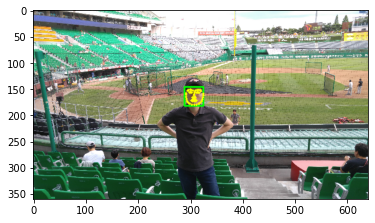

In [10]:
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

## 스티커 적용하기

* 랜드마크를 기준으로 눈썹위, 얼굴중앙에 스티커를 씌우면 된다.  
* 사진 왼쪽위부터 x값0, y값0

In [11]:
# 얼굴박스. 폭 182-146?
dlib_rect ,dlib_rect.width()

(rectangle(289,146,325,182), 37)

In [12]:
# 코 중심 기준
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print(landmark[30]) # nose위치
    # 코 랜드마크 x위치
    x = landmark[30][0] # 30 - 코 위치
    # 코 랜드마크 y위치 - 얼굴박스의 절반
    y = landmark[30][1] - dlib_rect.width()//2 # (//2: 2로 나눈몫)
    w = dlib_rect.width()
    h = dlib_rect.width()
    print ('(x,y):(%d,%d)'%(x,y))
    print ('(w,h) : ({},{})'.format(w,h))

(307, 163)
(x,y):(307,145)
(w,h) : (37,37)


* 준비해둔 스티커 이미지 적용

In [13]:
import os
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/king.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker,(w,h))
print(img_sticker.shape)

(37, 37, 3)


* 이미지의 시작은 top-left좌표부터이므로 원본에 스티커이미지 추가위해 x,y 좌표 조정

In [14]:
refined_x = x - w // 2  # left 코x좌표 - 얼굴박스 절반 (시작지점)
refined_y = y - h       # top 코위치-얼굴박스절반 (y시작지점 : y=눈썹위쯤 더 위로 올리기, 0에 가깝게)
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (289,108)


In [15]:
img_sticker[refined_y:]

array([], shape=(0, 37, 3), dtype=uint8)

In [16]:
# 원본이미지를 벗어난 스티커 부분 제거
img_sticker = img_sticker[-refined_y:]
print (img_sticker.shape)
# refined_y = 0 안넘어갈경우 주석처리
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(37, 37, 3)
(x,y) : (289,108)


* 원본이미지에 스티커 적용

In [17]:
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)

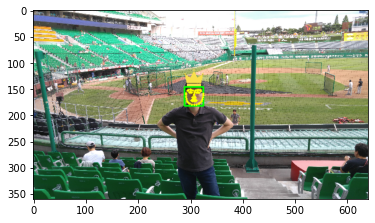

In [18]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

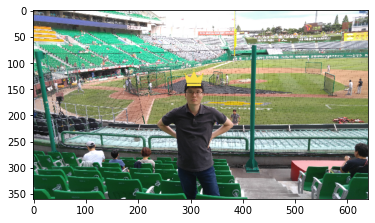

In [19]:
sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

# 프로젝트 :  고양이 수염 만들기

## 스티커 구하기, 만들기

## 얼굴검출, 랜드마크 검출하기

In [20]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

* cv2로 읽은후 BGR을 RGB로 변경후 이미지 확인

In [21]:
face_image = os.getenv('HOME')+"/aiffel/camera_sticker/images/face.jpg"

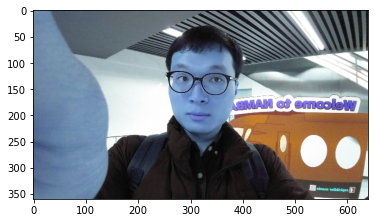

In [22]:
face_bgr = cv2.imread(face_image)
face_bgr = cv2.resize(face_bgr, (640, 360)) # 4:3 사이즈로 resize
face_bgr1 = face_bgr.copy() # 만약을 대비해 백업
plt.imshow(face_bgr1)
plt.show()


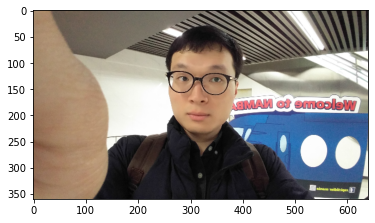

In [23]:
face_rgb = cv2.cvtColor(face_bgr1, cv2.COLOR_BGR2RGB)
face_rgb1 = face_rgb.copy() #백업2
plt.imshow(face_rgb)
plt.show()

* 얼굴박스 검출

In [24]:
import dlib
detector_hog = dlib.get_frontal_face_detector() #detector선언

In [25]:
dlib_rects = detector_hog(face_rgb, 1) #(image, num of img pyramid)

In [26]:
print(dlib_rects)   # 찾은 얼굴영역 좌표(??)

rectangles[[(236, 98) (390, 253)]]


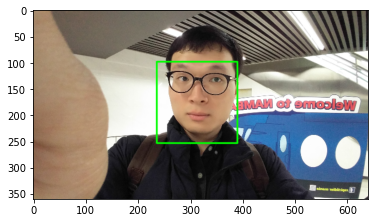

In [27]:
for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(face_rgb1, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

#face_show_rgb =  cv2.cvtColor(face_bgr, cv2.COLOR_BGR2RGB) #bgr백업한 것을 Rgb로 변환
plt.imshow(face_rgb1)
plt.show()

* 얼굴 랜드마크 찾기

In [28]:
# 모델 불러오기
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

In [29]:
list_landmarks = []
for dlib_rect in dlib_rects: #dlib_rects 얼굴box
    points = landmark_predictor(face_rgb1, dlib_rect)
    list_points = list(map(lambda p: (p.x,p.y), points.parts()))
    list_landmarks.append(list_points)
    
print(len(list_landmarks[0]))

68


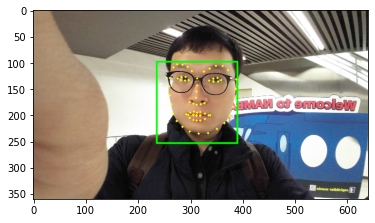

In [30]:
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(face_rgb1, point, 2, (255,255,0), -1) # yellow
        
plt.imshow(face_rgb1)
plt.show()

## 스티커 적용위치 확인하기

In [31]:
dlib_rect ,dlib_rect.width()

(rectangle(236,98,390,253), 155)

In [32]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # nose center index : 30
    x = landmark[30][0]
    y = landmark[30][1]
   
    print ('(x,y) : (%d,%d)'%(x,y))

(311, 167)
(x,y) : (311,167)


In [33]:
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat.png'
cat_sticker = cv2.imread(sticker_path)
cat_sticker = cv2.resize(cat_sticker, (155,155))
print (cat_sticker.shape)

(155, 155, 3)


* 박스의 가운데에 스티커를 위치시키면 될 것이다.

In [34]:
w = dlib_rect.width()//2

In [35]:
refined_x = x - w   # left
refined_y = y -w      # top
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (234,90)


## 스티커 적용하기

In [37]:
sticker_area = face_rgb1[refined_y:refined_y+cat_sticker.shape[0], refined_x:refined_x+cat_sticker.shape[1]]
face_rgb1[refined_y:refined_y+cat_sticker.shape[0], refined_x:refined_x+cat_sticker.shape[1]] = \
    np.where(cat_sticker==255,sticker_area,cat_sticker).astype(np.uint8) #cat이미지가 존재하면 사용, 아니면 배경이미지사용

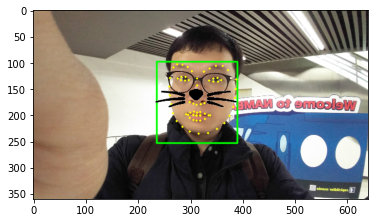

In [38]:
plt.imshow(face_rgb1)
plt.show()

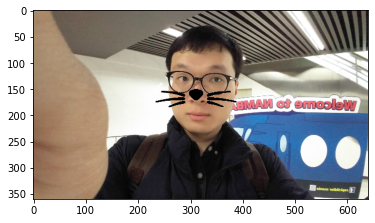

In [39]:
sticker_area = face_rgb[refined_y:refined_y+cat_sticker.shape[0], refined_x:refined_x+cat_sticker.shape[1]]
face_rgb[refined_y:refined_y+cat_sticker.shape[0], refined_x:refined_x+cat_sticker.shape[1]] = \
    np.where(cat_sticker==255,sticker_area,cat_sticker).astype(np.uint8)
plt.imshow(face_rgb)
plt.show()